In [1]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1
from IPython.display import clear_output

In [ ]:
!wget -q -O van_gog http://www.arthistory.ru/img/vangog/zvezdnaya_noch_vangog.jpg #van gog style img


!wget -q -O picasso https://i.pinimg.com/236x/af/50/30/af50302c553657de6726a901575a3ce6--picasso-drawing-picasso-paintings.jpg #picasso style img


!wget -q -O content https://upload.wikimedia.org/wikipedia/commons/2/25/Da_Vinci%27s_Mona_Lisa_with_original_colors_approximation.jpg   #content mg

clear_output()

In [2]:
%matplotlib inline
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


import torchvision.transforms as transforms
import torchvision.models as models

import copy
import warnings
warnings.filterwarnings('ignore')

In [10]:
 import numpy as np
 import matplotlib

In [ ]:
imsize = 256  


loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img_1 = image_loader('/content/van_gog') #van gog picture

style_img_2 = image_loader('/content/picasso') #picasso image

content_img = image_loader('/content/content') #content image



In [ ]:
unloader = transforms.ToPILImage() # tensor to picture

In [ ]:
def plot_tensor(img):
    plt.imshow(unloader(img.cpu().clone().squeeze(0)))

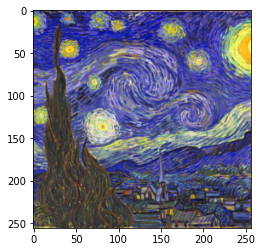

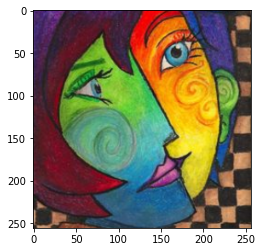

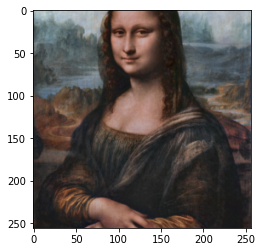

In [ ]:
plot_tensor(style_img_1)
plt.show()
plot_tensor(style_img_2)
plt.show()
plot_tensor(content_img)
plt.show()

### Content loss function

In [ ]:
class content_loss_(nn.Module):
    def __init__(self, final):
        super(content_loss_, self).__init__()
        self.final = final.detach()

    def forward(self, content):
        self.loss = F.mse_loss(content, self.final)
        return content

### Multi-style loss function

In [ ]:
class style_loss_(nn.Module):
    def Gram(self, input): #Gram matrix
        batch_size, channels, height, width = input.size()
        features = input.view(batch_size, channels, height * width)
        transposed_features = features.transpose(1, 2)
        out = features.bmm(transposed_features) / (channels * height * width)
        return out


    def __init__(self, style_picture, weights): #Gram matrix for style pictures
        super(style_loss_, self).__init__()
        self.first_style = self.Gram(style_picture[0]).clone().detach()
        self.second_style = self.Gram(style_picture[1]).clone().detach()
        self.weights = weights


    def forward(self, content):
        gram_matrix_ = self.Gram(content)

        # calculate losses

        first_style_loss = F.mse_loss(gram_matrix_, self.first_style)
        second_style_loss  = F.mse_loss(gram_matrix_, self.second_style)

        #updating weights
        first_style_loss *= self.weights[0]
        second_style_loss *= self.weights[1]

        # summing total loss
        self.loss = first_style_loss + second_style_loss

        return content

In [ ]:
class normalize(nn.Module):
    def __init__(self, mean, std):
        super(normalize, self).__init__()
      
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        # mean 
        self.std = torch.tensor(std).view(-1, 1, 1)
        # std

    def _get_norm(self, img):
       
        return (img - self.mean) / self.std
        # normalization


    def forward(self, imgs):
    
        return self._get_norm(imgs)

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# standard normalization values for VGG networks

In [ ]:
content_layers_default = ['conv_4']

# content layer in VGG
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# style layer in VGG

In [ ]:
cnn = models.vgg19(pretrained=True, progress=True).features.to(device).eval()
# VGG 19, pretrained on ImageNet

###Model and loss function (weighted sum of content and style losses):


In [ ]:
def style_model(cnn,
                               normalization_mean,
                               normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default,
                               weights=(0.5, 0.5)):


    cnn = copy.deepcopy(cnn)

    normalization = normalize(normalization_mean, normalization_std).to(device)

    content_losses = []

    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            print(f'Something is wrong! Please, check layer{layer.__class__.__name__}')


        model.add_module(name, layer)

        if name in content_layers:
            final = model(content_img).detach()
            content_loss = content_loss_(final)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            style_picture = []
            style_loss = []
            for style in style_img:
                style_picture.append(model(style).detach())
            style_loss = style_loss_(style_picture, weights)
            model.add_module(f'style_loss_{i}', style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], content_loss_) or isinstance(model[i], style_loss_):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

###Applying of model:

In [ ]:
def style_transfer(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=200,
                        style_weight=100000, content_weight=1, weights=(0.5, 0.5)):
    
        model, style_losses, content_losses = style_model(cnn,
            normalization_mean, normalization_std, style_img, content_img, weights = weights)
        optimizer = optim.Adam([input_img.requires_grad_()], lr = 1e-2)
        content = []
        style = []
        for epoch in range(num_steps):
            def closure():
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                model(input_img)

                style_score = 0
                content_score = 0

                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                
                style_score *= style_weight
                content_score *= content_weight
                loss = style_score + content_score
                loss.backward()
                style_loss.append(style_score.item())
                content_loss.append(content_score.item())
                
                return style_score + content_score
            style_loss = [] 
            content_loss = []
            optimizer.step(closure)
            if epoch > 5:

                content.append(np.mean(content_loss))
                style.append(np.mean(style_loss))

                clear_output(wait=True)

                plt.title('Content Loss')
                plt.xlabel('Number of Steps')
                plt.plot(content)
                plt.show()

                plt.title('Style Loss')
                plt.xlabel('Number of Steps')
                plt.plot(style)
                plt.show()

                plot_tensor(input_img)
                plt.show()

        input_img.data.clamp_(0, 1)

        return input_img

###Apply model to our images with weights of style pictures is equal to (1, 0)

In [ ]:
input_img = content_img.clone()

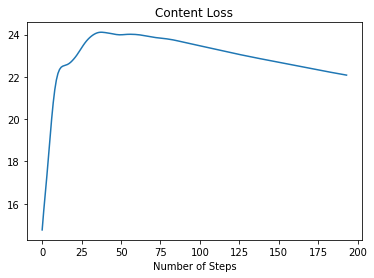

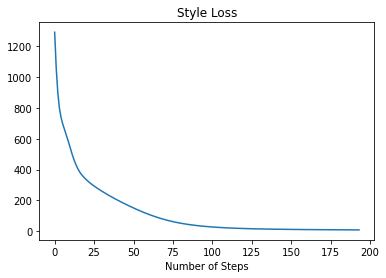

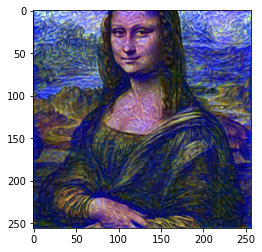

In [ ]:
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img, weights= (1,0))

####We only got the influence of the first style picture. That is, in fact, the general style transfer.

### The same for the second style image (weights = (0,1))

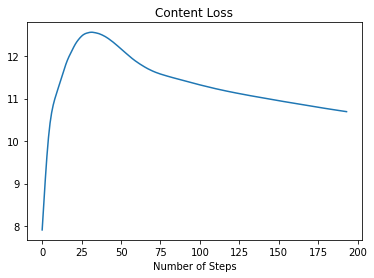

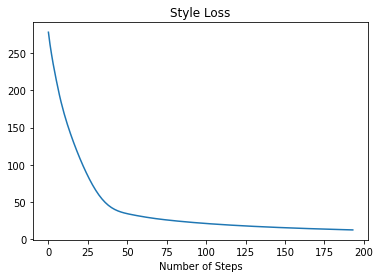

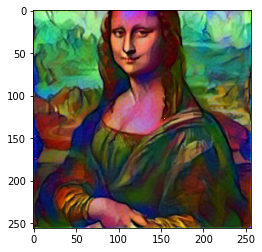

In [ ]:
input_img = content_img.clone()
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img, weights= (0,1))

### Let's combine both style images in equal parts

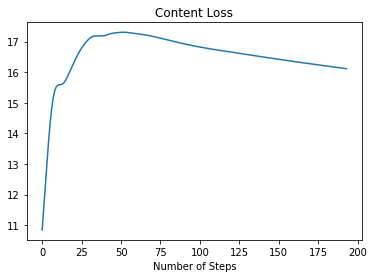

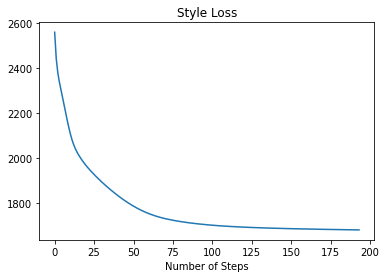

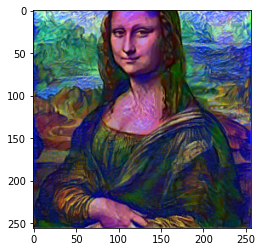

In [ ]:
input_img = content_img.clone()
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img, weights= (1,1))

####We get multi-style transfer from 2 style images to Mona Lisa. It looks very cool!

###Keep the style weights the same, and increase the content weight from 1 to 100

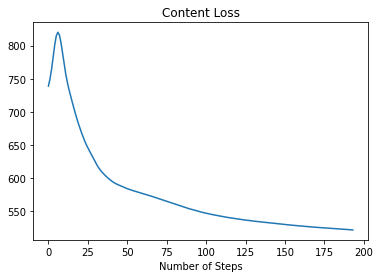

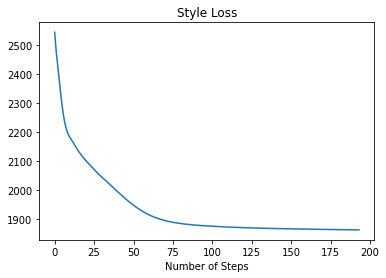

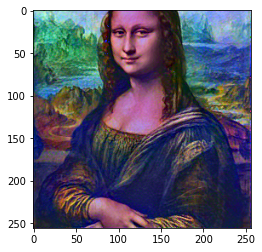

In [ ]:
input_img = content_img.clone()
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2),input_img, style_weight=100000, content_weight=100, weights= (1,1))

####The picture retained more content, however we can still see the style of style images in the final image. Value of style loss increased.

###Now let's increase the weight of the first style first and then the second one



####(2,1)

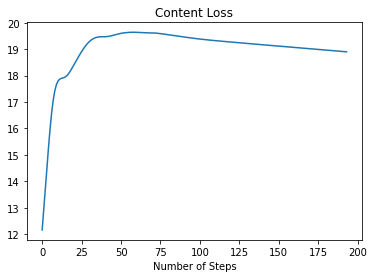

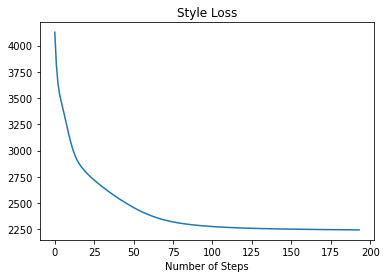

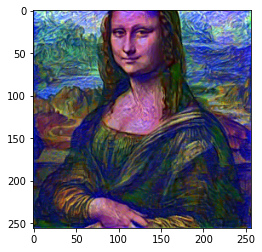

In [ ]:
input_img = content_img.clone()
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img , weights= (2,1))

####(1,2)

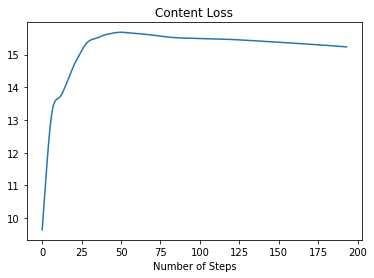

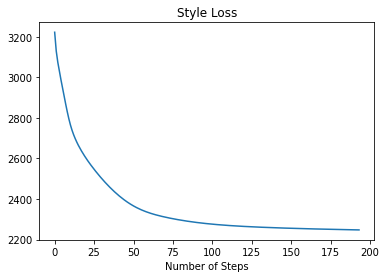

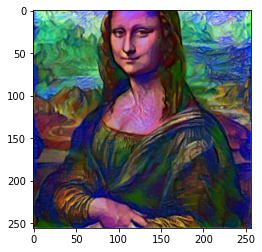

In [ ]:
input_img = content_img.clone()
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img, weights= (1,2))

#### We can see that a style image with a higher weight has a greater impact on the style of final image.

##We have tried different weghted style loss functions. Let's try to change content loss function. Change mse_loss to l1_loss.

In [ ]:
class content_loss_l1(nn.Module):
    def __init__(self, final):
        super(content_loss_l1, self).__init__()
        self.final = final.detach()

    def forward(self, content):
        self.loss = F.l1_loss(content, self.final)
        return content


class style_loss_l1(nn.Module):
    def Gram(self, input): #Gram matrix
        batch_size, channels, height, width = input.size()
        features = input.view(batch_size, channels, height * width)
        transposed_features = features.transpose(1, 2)
        out = features.bmm(transposed_features) / (channels * height * width)
        return out


    def __init__(self, style_picture, weights): #Gram matrix for style pictures
        super(style_loss_l1, self).__init__()
        self.first_style = self.Gram(style_picture[0]).clone().detach()
        self.second_style = self.Gram(style_picture[1]).clone().detach()
        self.weights = weights


    def forward(self, content):
        gram_matrix_ = self.Gram(content)

        # calculate losses

        first_style_loss = F.l1_loss(gram_matrix_, self.first_style)
        second_style_loss  = F.l1_loss(gram_matrix_, self.second_style)

        #updating weights
        first_style_loss *= self.weights[0]
        second_style_loss *= self.weights[1]

        # summing total loss
        self.loss = first_style_loss + second_style_loss

        return content

def style_model_1(cnn,
                               normalization_mean,
                               normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default,
                               weights=(0.5, 0.5)):


    cnn = copy.deepcopy(cnn)

    normalization = normalize(normalization_mean, normalization_std).to(device)

    content_losses = []

    style_losses = []

    model = nn.Sequential(normalization)

    i = 0 
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            print(f'Something is wrong! Please, check layer{layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            final = model(content_img).detach()
            content_loss = content_loss_l1(final)
            model.add_module("content_loss_l1{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            style_picture = []
            style_loss = []
            for style in style_img:
                style_picture.append(model(style).detach())
            style_loss = style_loss_l1(style_picture, weights)
            model.add_module(f'style_loss_l1{i}', style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], content_loss_l1) or isinstance(model[i], style_loss_l1):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


def style_transfer_1(cnn, normalization_mean, normalization_std,
                        content_img, style_img, input_img, num_steps=200,
                        style_weight=100000, content_weight=1, weights=(0.5, 0.5)):
    
        model, style_losses, content_losses = style_model_1(cnn,
            normalization_mean, normalization_std, style_img, content_img, weights = weights)
        optimizer = optim.Adam([input_img.requires_grad_()], lr = 1e-2)
        content = []
        style = []
        for epoch in range(num_steps):
            def closure():
                input_img.data.clamp_(0, 1)
                optimizer.zero_grad()
                model(input_img)

                style_score = 0
                content_score = 0
                
                for sl in style_losses:
                    style_score += sl.loss
                for cl in content_losses:
                    content_score += cl.loss

                
                style_score *= style_weight
                content_score *= content_weight
                loss = style_score + content_score
                loss.backward()
                style_loss.append(style_score.item())
                content_loss.append(content_score.item())
                
                return style_score + content_score
            style_loss = [] 
            content_loss = []
            optimizer.step(closure)
            if epoch > 5:

                content.append(np.mean(content_loss))
                style.append(np.mean(style_loss))

                clear_output(wait=True)

                plt.title('Content Loss')
                plt.xlabel('Number of Steps')
                plt.plot(content)
                plt.show()

                plt.title('Style Loss')
                plt.xlabel('Number of Steps')
                plt.plot(style)
                plt.show()

                plot_tensor(input_img)
                plt.show()

        input_img.data.clamp_(0, 1)

        return input_img

In [ ]:
input_img = content_img.clone()

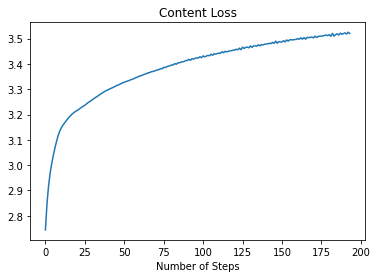

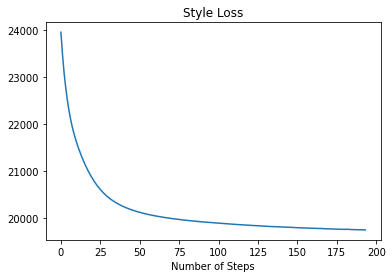

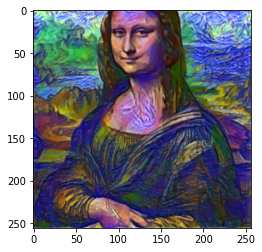

In [ ]:
output_1 = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img, weights= (1,1))

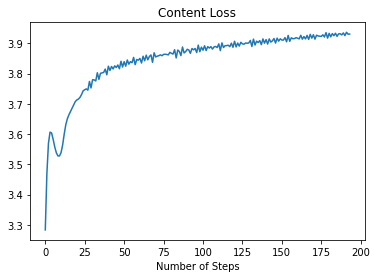

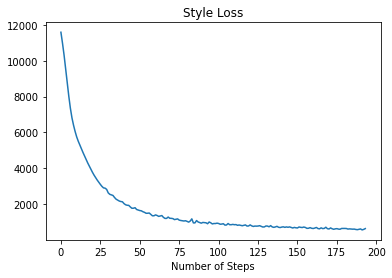

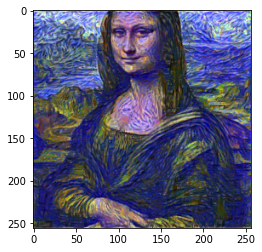

In [ ]:
input_img = content_img.clone()
output_1 = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img, weights= (1,0))

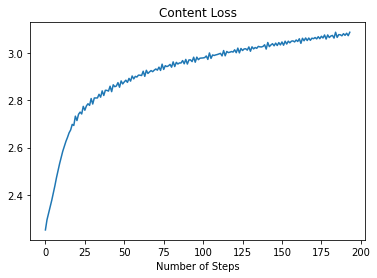

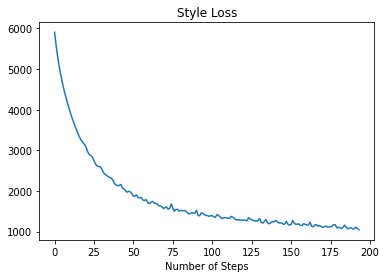

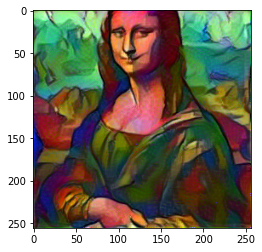

In [ ]:
input_img = content_img.clone()
output_1 = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, (style_img_1, style_img_2), input_img, weights= (0,1))

####Note that the results obtained with l1 look visually better than with mse. However, the content loss grows for the model with l1. This means that you need to increase the weight of the content in this case. Since the model with l1 performed better, we will use it.

##Let's look at more examples of style pictures and content images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


####Content images:

In [ ]:
content_img_M = image_loader('/content/drive/MyDrive/Картинки/personal_photo_1,4mb.jpg')
content_img_E = image_loader('/content/drive/MyDrive/Картинки/content_images/photo_2021-03-20_20-54-51.jpg')
content_img_A = image_loader('/content/drive/MyDrive/Картинки/photo2378632599279085482.jpg')
content_img_AA = image_loader('/content/drive/MyDrive/Картинки/Alex_sq256.jpg')
content_img_L = image_loader('/content/drive/MyDrive/Картинки/content_images/b8232694-9633-472d-8887-c4a621a9f3e6.jpg')
content_img_list = image_loader('/content/drive/MyDrive/Картинки/content_images/8BAp3MEc7js.jpg')
content_img_beach = image_loader('/content/drive/MyDrive/Картинки/content_images/colva_beach_sq.jpg')
content_img_bridge = image_loader('/content/drive/MyDrive/Картинки/content_images/GoldenGateBridge.jpg')
content_img_tower = image_loader('/content/drive/MyDrive/Картинки/content_images/eiffel_tower.jpg')
content_img_rose = image_loader('/content/drive/MyDrive/Картинки/content_images/Без названия (1).jpg')
content_img_cathedral = image_loader('/content/drive/MyDrive/Картинки/content_images/images.jpg')

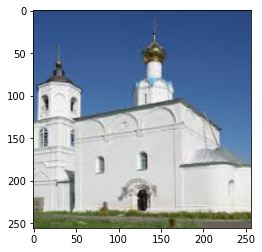

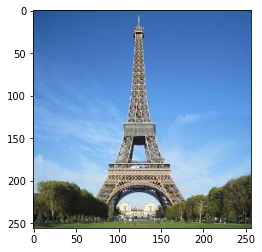

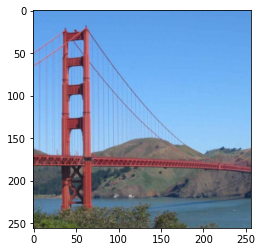

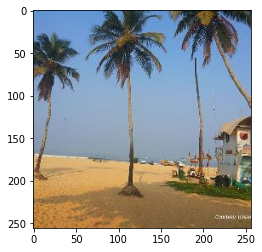

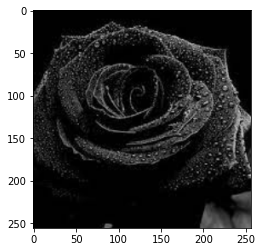

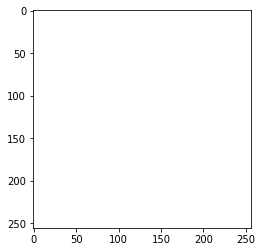

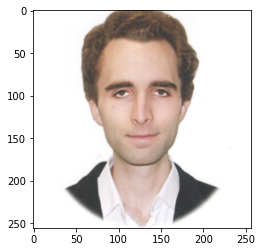

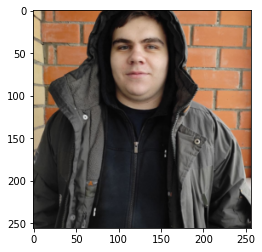

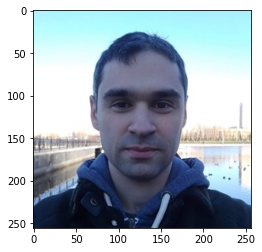

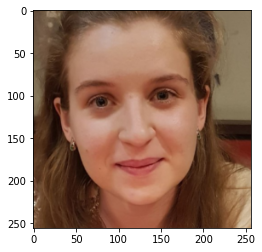

In [ ]:
plot_tensor(content_img_cathedral)
plt.show()
plot_tensor(content_img_tower)
plt.show()
plot_tensor(content_img_bridge)
plt.show()
plot_tensor(content_img_beach)
plt.show()
plot_tensor(content_img_rose)
plt.show()
plot_tensor(content_img_list)
plt.show()
plot_tensor(content_img_M)
plt.show()
plot_tensor(content_img_E)
plt.show()
plot_tensor(content_img_AA)
plt.show()
plot_tensor(content_img_L)
plt.show()

###Style images:

In [ ]:
style_img_mandala = image_loader('/content/drive/MyDrive/Картинки/mandala.jpeg')
style_img_black_zigzag = image_loader('/content/drive/MyDrive/Картинки/style_images/black_zigzag.jpg')
style_img_texture = image_loader('/content/drive/MyDrive/Картинки/style_images/red_texture_sq.jpg')
style_img_monet = image_loader('/content/drive/MyDrive/Картинки/style_images/monet_800600.jpg')
style_img_color_zigzag = image_loader('/content/drive/MyDrive/Картинки/style_images/zigzag_colorful.jpg')
style_img_stars = image_loader('/content/drive/MyDrive/Картинки/style_images/Без названия.jpg')
style_img_cathe = image_loader('/content/drive/MyDrive/Картинки/style_images/front_1.jpg')
style_img_ac = image_loader('/content/drive/MyDrive/Картинки/style_images/16211629_1201543826_f_7592038.jpg')
style_img_acac = image_loader('/content/drive/MyDrive/Картинки/style_images/1587109050_2-p-kislotnie-foni-15.jpg')
style_img_alsk = image_loader('/content/drive/MyDrive/Картинки/style_images/images (1).jpg')
style_img_frac = image_loader('/content/drive/MyDrive/Картинки/style_images/images (2).jpg')
style_img_tt = image_loader('/content/drive/MyDrive/Картинки/620x462_1_52bcab30d3eb66495ea9f58e7cd0217d@1000x745_0xac120003_17389670351569923897.jpg')

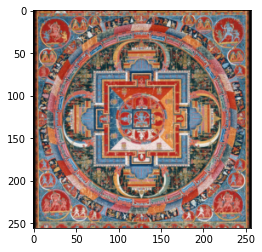

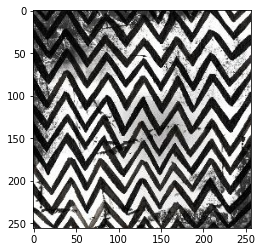

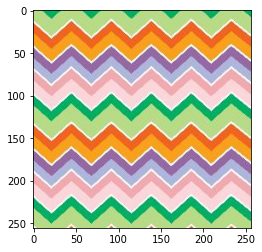

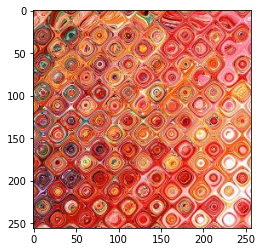

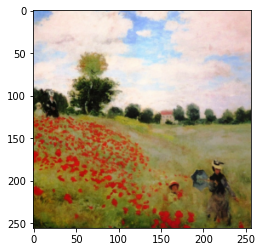

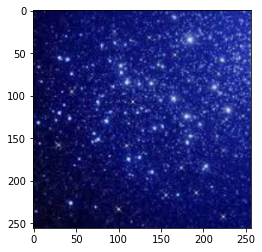

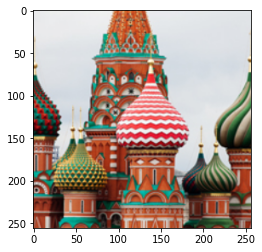

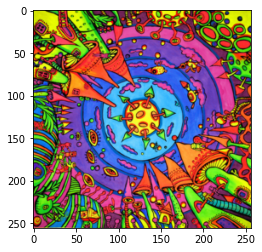

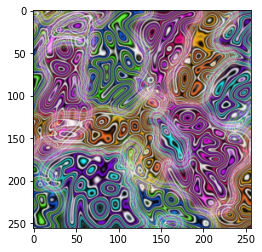

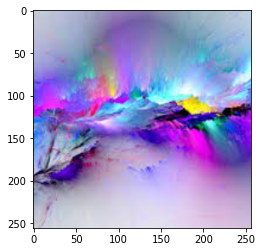

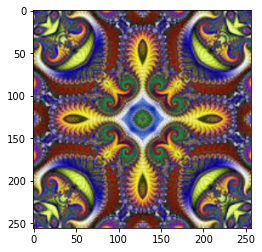

In [ ]:
plot_tensor(style_img_mandala)
plt.show()
plot_tensor(style_img_black_zigzag)
plt.show()
plot_tensor(style_img_color_zigzag)
plt.show()
plot_tensor(style_img_texture)
plt.show()
plot_tensor(style_img_monet)
plt.show()
plot_tensor(style_img_stars)
plt.show()
plot_tensor(style_img_cathe)
plt.show()
plot_tensor(style_img_ac)
plt.show()
plot_tensor(style_img_acac)
plt.show()
plot_tensor(style_img_alsk)
plt.show()
plot_tensor(style_img_frac)
plt.show()

### Style of the Cathedral of Vasily the Blessed and color zigzag



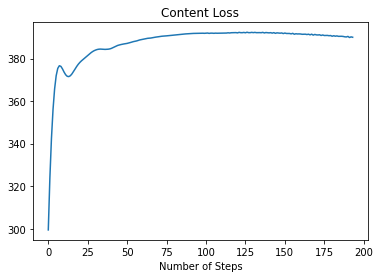

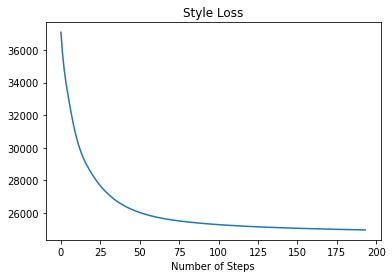

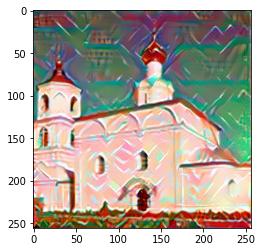

In [ ]:
input_img = content_img_cathedral.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_cathedral, (style_img_cathe, style_img_color_zigzag), input_img,content_weight=100, weights= (1,1))

#### The style of the starry sky

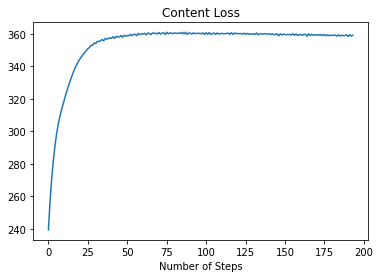

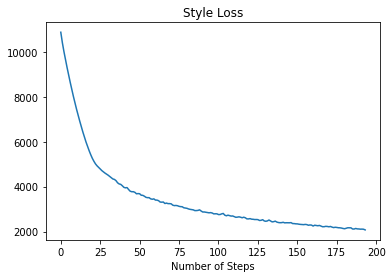

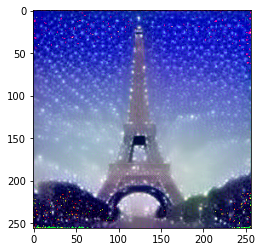

In [ ]:
input_img = content_img_tower.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_tower, (style_img_acac, style_img_stars), input_img,content_weight=100, weights= (0,1))

####The style of the starry sky and patterns with stains

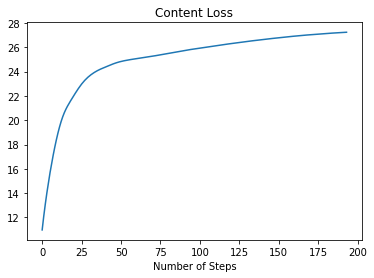

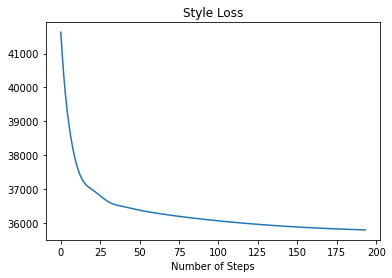

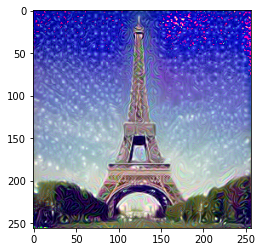

In [ ]:
input_img = content_img_tower.clone()
output = style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_tower, (style_img_acac, style_img_stars),input_img , weights= (1,5))

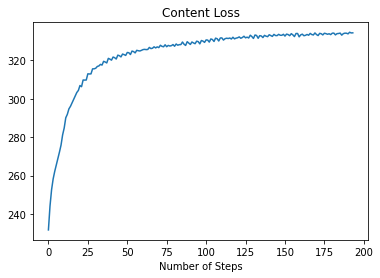

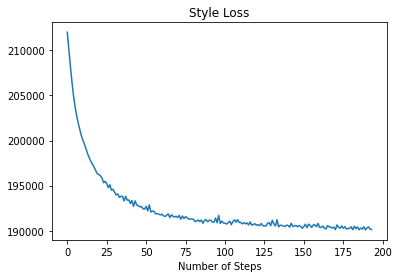

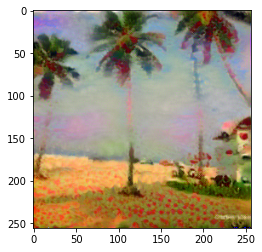

In [ ]:
input_img = content_img_beach.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_beach, (style_img_monet, style_img_ac), input_img,  content_weight=100, weights= (5,2))

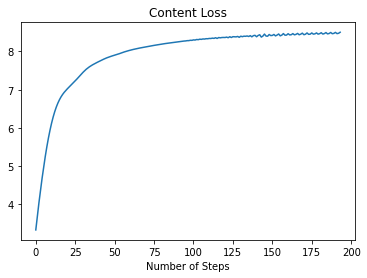

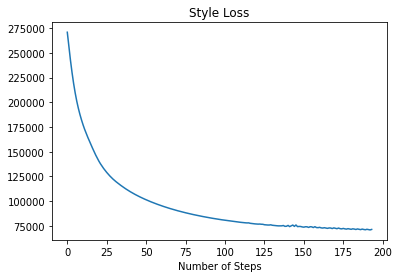

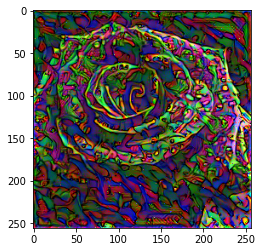

In [ ]:
input_img = content_img_rose.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_rose, (style_img_acac, style_img_ac),input_img , weights= (1,3))

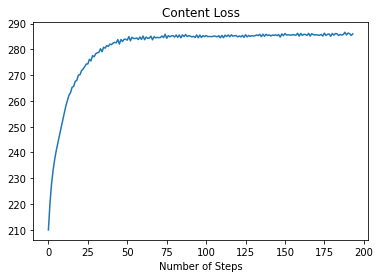

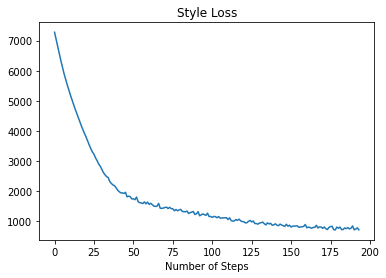

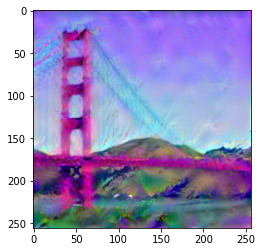

In [ ]:
input_img = content_img_bridge.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_bridge, (style_img_alsk, style_img_1),input_img,content_weight=100, weights= (1,0))

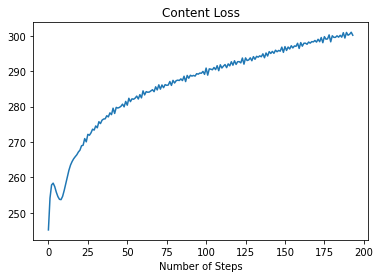

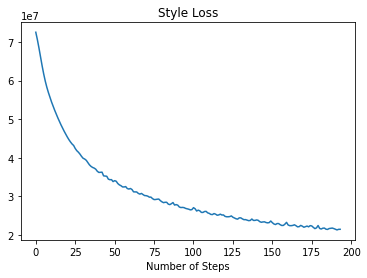

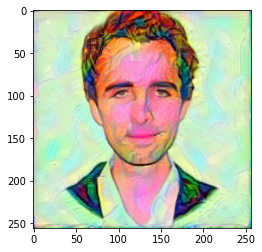

In [ ]:
input_img = content_img_M.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_M, (style_img_1, style_img_2),input_img, content_weight=100, weights= (100,10000))

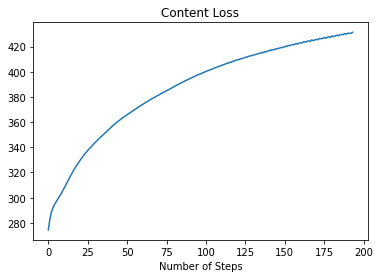

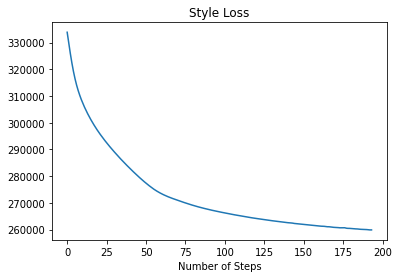

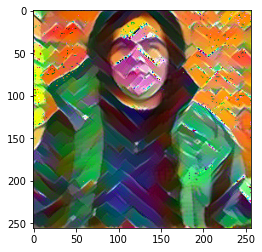

In [ ]:
input_img =  content_img_E.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_E, (style_img_2, style_img_color_zigzag),input_img , content_weight=100, weights= (10,11))

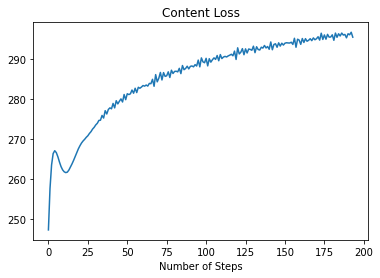

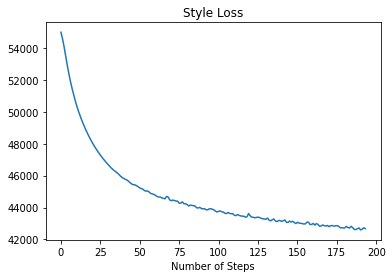

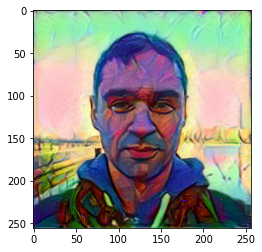

In [ ]:
input_img =  content_img_AA.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_AA, (style_img_2, style_img_1),input_img,content_weight=100, weights= (3,2))

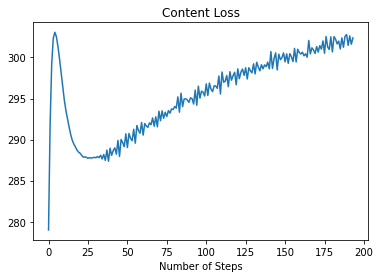

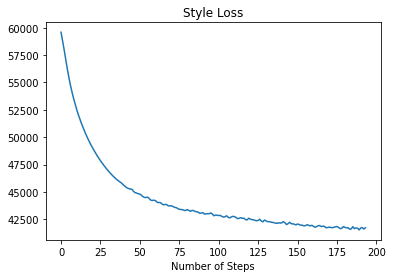

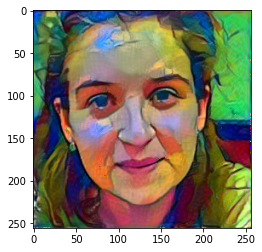

In [ ]:
input_img =  content_img_L.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_L, (style_img_1, style_img_2), input_img,content_weight=100, weights= (2,3))

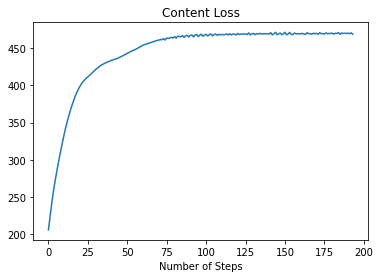

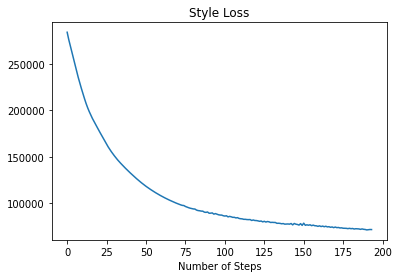

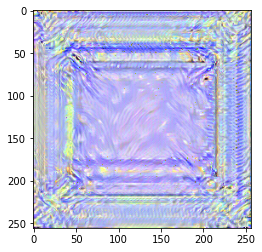

In [ ]:
input_img = content_img_list.clone()
output = style_transfer_1(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img_list, (style_img_stars, style_img_1), input_img,content_weight=100, weights= (2,10))

In [ ]:
vgg_total_params = sum(p.numel() for p in cnn.parameters())

In [ ]:
vgg_total_params

20024384

###Let us try to reproduce the result with alexnet

In [ ]:
cnn1 = models.alexnet(pretrained=True, progress=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
alexnet_total_params = sum(p.numel() for p in cnn1.parameters())

In [ ]:
alexnet_total_params

2469696

In [ ]:
# alexnet contain in ~ 10 times less parameters

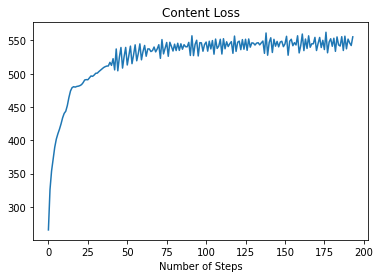

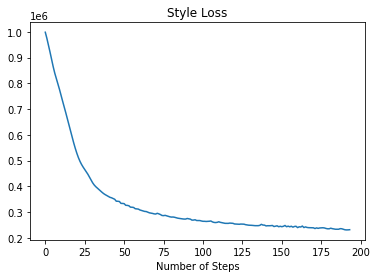

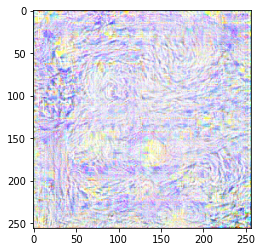

In [ ]:
input_img = content_img_list.clone()
output = style_transfer_1(cnn1, cnn_normalization_mean, cnn_normalization_std,
                            content_img_list, (style_img_stars, style_img_1), input_img,content_weight=100, weights= (2,10))

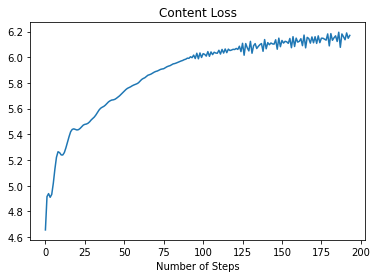

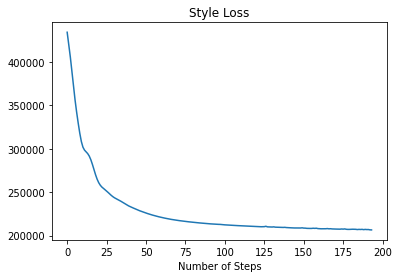

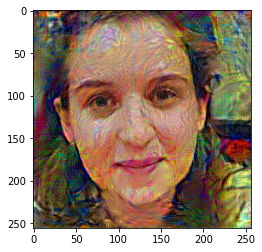

In [ ]:
input_img =  content_img_L.clone()
output = style_transfer_1(cnn1, cnn_normalization_mean, cnn_normalization_std,
                            content_img_L, (style_img_1, style_img_2), input_img,content_weight=1, weights= (2,3))

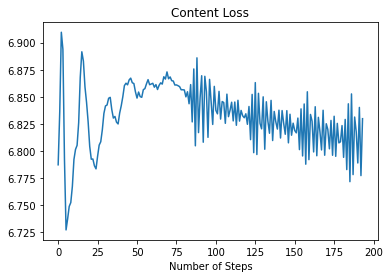

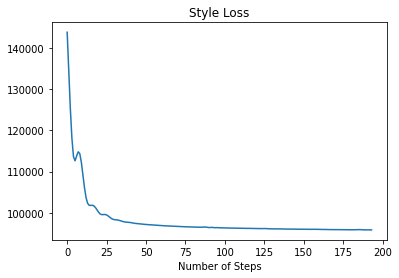

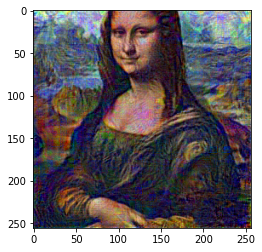

In [ ]:
input_img =  content_img.clone()
output = style_transfer_1(cnn1, cnn_normalization_mean, cnn_normalization_std,
                            content_img_L, (style_img_1, style_img_2), input_img,content_weight=1, weights= (1,1))

####The result turned out to be visually worse.